# G2M insight for Cab Investment firm
The purpose of this notebook is to run some proof-of-concept models to better understand the relationship between different aspects of the customer and the profit per KM. The profit per KM is represented as the USD to determine the amount of profit. 


Data were stored into 4 main .csv files, all of which are collected from 31/01/2016 to 31/12/2018. The specifc details of all data sets are as follows:

Cab_Data.csv – this file includes details of transaction for 2 cab companies

Customer_ID.csv – this is a mapping table that contains a unique identifier which links the customer’s demographic details

Transaction_ID.csv – this is a mapping table that contains transaction to customer mapping and payment mode

City.csv – this file contains list of US cities, their population and number of cab users

In [24]:
#Prerequisite libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape

## Table of Contents
1. [Data Acquisition](#DA) - Data source
2. [Exploratory Data Analysis](#EDA) - Insights of the key characteristics
3. [Feature Engineering](#FE) - Feature discovery
4. [Modelling](#M) - Model development
5. [Error Analysis](#EA) - Prediction interval
6. [Conclusion](#CN)
7. [Next Steps](#NS)

## 1. Data Acquisition <a class="anchor" id="DA"></a>

Data sets are fetched from reading .csv files.

In [25]:
cab=pd.read_csv("Cab_Data.csv")
cab.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [26]:
#Knowing the general information about the cab data
cab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction ID  359392 non-null  int64  
 1   Date of Travel  359392 non-null  int64  
 2   Company         359392 non-null  object 
 3   City            359392 non-null  object 
 4   KM Travelled    359392 non-null  float64
 5   Price Charged   359392 non-null  float64
 6   Cost of Trip    359392 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 19.2+ MB


In [27]:
city=pd.read_csv("City.csv")
city.head()

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [28]:
#Knowing the general information about the city data
city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   City        20 non-null     object
 1   Population  20 non-null     object
 2   Users       20 non-null     object
dtypes: object(3)
memory usage: 608.0+ bytes


In [29]:
customer=pd.read_csv("Customer_ID.csv")
customer.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [30]:
#Knowing the general information about the customer data
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         49171 non-null  int64 
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income (USD/Month)  49171 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [31]:
transaction=pd.read_csv("Transaction_ID.csv")
transaction.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


In [32]:
#Knowing the general information about the transaction data
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  440098 non-null  int64 
 1   Customer ID     440098 non-null  int64 
 2   Payment_Mode    440098 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


## 2. Exploratory Data Analysis <a class="anchor" id="EDA"></a>
### 2.1 Data information
Understanding the given dataset and helps clean up the dataset.

In [33]:
#Merging customer and transaction data, 1 customer may have 1 or multiple transactions and 1 transaction only belongs to 1 customer
tran_cust=transaction.merge(customer,on='Customer ID')
tran_cust=tran_cust.sort_values('Transaction ID')
tran_cust.head()

,Transaction ID,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,29290,Card,Male,28,10813
3,10000012,27703,Card,Male,27,9237
7,10000013,28712,Cash,Male,53,11242
11,10000014,28020,Cash,Male,23,23327
15,10000015,27182,Card,Male,33,8536


In [34]:
#Merging cab and city data, 1 city may have 1 or multiple transactions and 1 transaction only belongs to 1 city
cab_city=cab.merge(city,on='City')
cab_city.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635,"814,885","24,701"
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854,"814,885","24,701"
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632,"814,885","24,701"
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602,"814,885","24,701"
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776,"814,885","24,701"


In [35]:
#Merging all data sets to get final data
data=cab_city.merge(tran_cust,on='Transaction ID')
data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635,"814,885","24,701",29290,Card,Male,28,10813
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854,"814,885","24,701",27703,Card,Male,27,9237
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632,"814,885","24,701",28712,Cash,Male,53,11242
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602,"814,885","24,701",28020,Cash,Male,23,23327
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776,"814,885","24,701",27182,Card,Male,33,8536


### 2.2 Categorical Variables
Finding categorical variables that need to be one-hot encoded in the future.

In [36]:
categorical=[]

#Finding character variables in the data frame
for i in data.columns:
    if data[i].dtype=='O':
        categorical.append(i)

In [37]:
categorical

['Company', 'City', 'Population', 'Users', 'Payment_Mode', 'Gender']

### 2.3 Missing values
Detecting missing values in the dataframe in order to avoid bias or the loss of accuracy.

In [38]:
data.isnull().sum().value_counts()

0    14
dtype: int64

### 2.4 Duplicate rows
Detecting duplicate rows in the dataframe in order to avoid bias or the loss of accuracy.

In [39]:
data.duplicated().value_counts()

False    359392
dtype: int64

### 2.5 Target label
After that, we have to add a specific goal for our model, namely Profit per KM. It is also important to make sure the distribution is not skewed.

In [40]:
data['Total Profit']=data['Price Charged']-data['Cost of Trip']
data['Profit per KM']=data['Total Profit']/data['KM Travelled']
data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Total Profit,Profit per KM
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635,"814,885","24,701",29290,Card,Male,28,10813,57.315,1.882266
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854,"814,885","24,701",27703,Card,Male,27,9237,23.666,0.826904
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632,"814,885","24,701",28712,Cash,Male,53,11242,27.568,3.049558
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602,"814,885","24,701",28020,Cash,Male,23,23327,25.798,0.777751
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776,"814,885","24,701",27182,Card,Male,33,8536,16.844,1.929439


Text(0.5, 1.0, 'Distribution of Profit per KM')

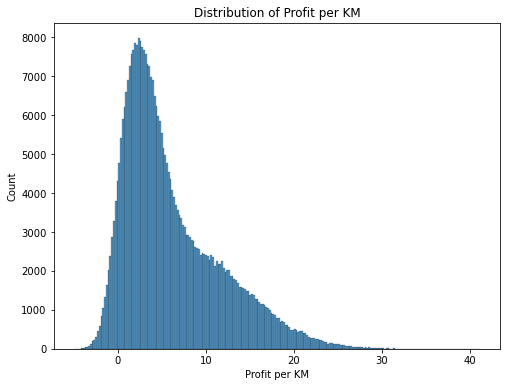

In [18]:
fig,ax=plt.subplots(figsize=(8,6))
#ax.set_xlim(0,)
sns.histplot(data['Profit per KM'],ax=ax).set_title('Distribution of Profit per KM')

It is clear in the plot that the distribution of Profit per KM is not normally distributed but positive skewed. Also, the high standard deviation proves that data are far from the mean. We will address this issue in the follwing section.

## 3. Feature Engineering <a class="anchor" id="FE"></a>

A variaty of pre-processing steps on dealing with features to improve the performance of models.

### 3.1 One-hot encoding
One-hot encoding for those categorical variables.

In [19]:
data=data.drop(columns=['Population','Users'])

In [20]:
data

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Total Profit,Profit per KM
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,57.3150,1.882266
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,23.6660,0.826904
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash,Male,53,11242,27.5680,3.049558
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,28020,Cash,Male,23,23327,25.7980,0.777751
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,27182,Card,Male,33,8536,16.8440,1.929439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10440101,43108,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,52392,Cash,Male,24,15651,5.8800,1.225000
359388,10440104,43104,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,53286,Cash,Male,32,6528,6.9020,0.821667
359389,10440105,43105,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,52265,Cash,Male,56,7966,87.4200,3.150270
359390,10440106,43105,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,52175,Card,Male,32,6423,32.1420,3.652500


In [21]:
#Label factorization for those 'object' features
for i in data.columns[data.dtypes=='O']:
    #print(i)
    data[i]=data[i].factorize()[0]

In [22]:
#One-hot encoding for each categorical variables
categorical.remove('Population')
categorical.remove('Users')
for i in categorical:
    
    #Renameing variables to avoid repetition and ambiguity
    one_hot=pd.get_dummies(data[i]).rename(columns=lambda x:i+'_'+str(x))
    
    #Removal of the last one-hot column to avoid multicollinearity
    one_hot=one_hot.iloc[:,:-1]
    data=data.drop(columns=i)
    data=data.join(one_hot)

In [23]:
data.head()

,Transaction ID,Date of Travel,KM Travelled,Price Charged,Cost of Trip,Customer ID,Age,Income (USD/Month),Total Profit,Profit per KM,...,City_10,City_11,City_12,City_13,City_14,City_15,City_16,City_17,Payment_Mode_0,Gender_0
0,10000011,42377,30.45,370.95,313.635,29290,28,10813,57.315,1.882266,...,0,0,0,0,0,0,0,0,1,1
1,10000012,42375,28.62,358.52,334.854,27703,27,9237,23.666,0.826904,...,0,0,0,0,0,0,0,0,1,1
2,10000013,42371,9.04,125.20,97.632,28712,53,11242,27.568,3.049558,...,0,0,0,0,0,0,0,0,0,1
3,10000014,42376,33.17,377.40,351.602,28020,23,23327,25.798,0.777751,...,0,0,0,0,0,0,0,0,0,1
4,10000015,42372,8.73,114.62,97.776,27182,33,8536,16.844,1.929439,...,0,0,0,0,0,0,0,0,1,1


### 3.2 Correlation coefficient
A high correlation coefficient would lead to a chance that the performance of the model will be impacted by the multicollinearity.

In [24]:
#Finding the strongest correlated variable with KWH
corr_coef=data.corr()
corr_feat=corr_coef["Profit per KM"].copy()
corr_feat=corr_feat.sort_values(ascending=False)
corr_feat.index[1]

'Total Profit'

In [25]:
#Dropping the highly correlated feature
data=data.drop(columns=['Total Profit'])

### 3.3 Outlier removal
Outliers are those data points which differs significantly from other observations present in given dataset. It can occur because of variability in measurement and due to misinterpretation in filling data points.

One of the simplest methods for detecting outliers is box plots. A box plot is a graphical display for describing the distributions of the data. Box plots use the median and the lower and upper quartiles. 

Text(0.5, 0, 'feature')

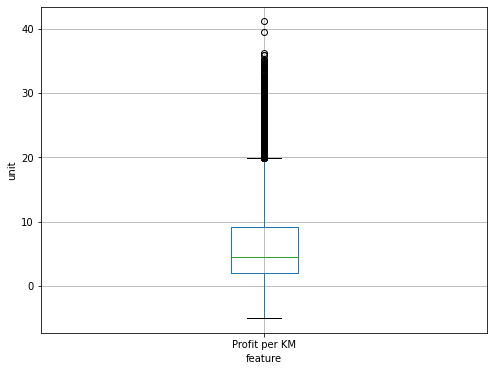

In [26]:
#Box plot
boxplot=data.boxplot(column=['Profit per KM'],figsize=(8,6))
boxplot.set_ylabel('unit')
boxplot.set_xlabel('feature')

In [27]:
num1=data.shape[0]
Q1 = data['Profit per KM'].quantile(0.25)
Q3 = data['Profit per KM'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (data['Profit per KM'] >= Q1 - 1.5 * IQR) & (data['Profit per KM'] <= Q3 + 1.5 *IQR)
data=data.loc[filter]

while data.shape[0]!=num1:
    num1=data.shape[0]
    Q1 = data['Profit per KM'].quantile(0.25)
    Q3 = data['Profit per KM'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (data['Profit per KM'] >= Q1 - 1.5 * IQR) & (data['Profit per KM'] <= Q3 + 1.5 *IQR)
    data=data.loc[filter]

Text(0.5, 0, 'feature')

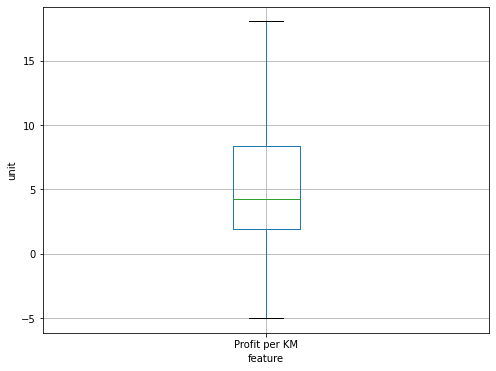

In [28]:
boxplot=data.boxplot(column=['Profit per KM'],figsize=(8,6))
boxplot.set_ylabel('unit')
boxplot.set_xlabel('feature')

Text(0.5, 1.0, 'Distribution of Profit per KM')

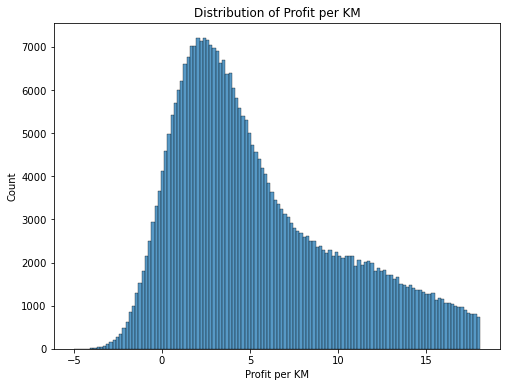

In [29]:
fig,ax=plt.subplots(figsize=(8,6))
#ax.set_xlim(0,)
sns.histplot(data['Profit per KM'],ax=ax).set_title('Distribution of Profit per KM')

## 4. Modelling <a class="anchor" id="M"></a>

We try out Random Forest, Xgboost and deep learning algorithms on predicting the KWH.

In [30]:
#Input of data
X=data.drop(columns=['Transaction ID','Date of Travel','Customer ID','Profit per KM'])

#Output of data
y=data['Profit per KM']

In [31]:
#Data normalization
Scaler=StandardScaler()
X_=Scaler.fit_transform(X)

In [32]:
#75% of training and 25% of testing
X_train,X_test,y_train,y_test=train_test_split(X_,y,test_size=0.25,random_state=0)

### 4.1 Random Forest
The reason why we choose random forest is that it is flexible to apply to regression problems and convenient to improve the model performance.

In [33]:
rd_regressor=RandomForestRegressor(random_state=100,n_jobs=-1,verbose=True)
rd_regressor.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestRegressor(n_jobs=-1, random_state=100, verbose=True)

In [34]:
rd_regressor_train_preds =rd_regressor.predict(X_train)
rd_regressor_preds=rd_regressor.predict(X_test)

model_train_mae=mean_absolute_error(y_train,rd_regressor_train_preds)
model_mae=mean_absolute_error(y_test,rd_regressor_preds)

print(f"Model train mae={model_train_mae},test mae ={model_mae}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s


Model train mae=0.02410453504563584,test mae =0.060238519544471854


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


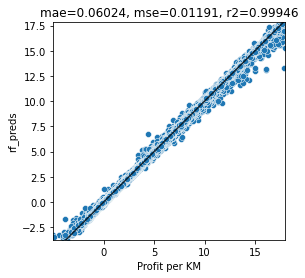

mae=0.060238519544471854
mse=0.011908852469724528
r2_score=0.9994609483826659


In [35]:
sns.scatterplot(x=y_test, y=rd_regressor_preds) 

ax=plt.gca()
ax.set_aspect('equal')
ax.set_xlim([min(y_test),max(y_test)])
ax.set_ylim([min(rd_regressor_preds),max(rd_regressor_preds)])
lims=[
    np.min([ax.get_xlim(),ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(),ax.get_ylim()]),  # max of both axes
]

ax.plot(lims,lims,'k-',alpha=0.75,zorder=2)
# plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('rf_preds')
plt.title(f"mae={model_mae:.5f}, " +
          f"mse={mean_squared_error(y_test,rd_regressor_preds):.5f}, " +
          f"r2={r2_score(y_test,rd_regressor_preds):.5f}")

plt.show() 

print(f"mae={model_mae}")
print(f"mse={mean_squared_error(y_test,rd_regressor_preds)}")
print(f"r2_score={r2_score(y_test,rd_regressor_preds)}")

## 6. Conclusion <a class="anchor" id="CN"></a>

We pre-processed the data and split the data into 75% for training and 25% for testing, then trained the model and tuned hyperparameters by k-fold validation, which was followed by looking at the R^2, MAE, MSE metrics.

All in all, if we have a data set that includes many housing characteristics and would like to predict its profit per KM, we may as well try using the random forest algorithm since it behaves well in performance metrics.

## 7. Next steps <a class="anchor" id="NS"></a>

In order to further improve the model performance, our next step is to contact SMEs (Subject Matter Experts), who can use their experience to identify and engineer new features (e.g., transformation or combination of some important features, different regions, etc.). We also recommend the user input on modeling and error analysis to check whether our results are consistent with their business experience and intuition.

In [57]:
from datetime import datetime

In [41]:
data['Date of Travel'] = pd.TimedeltaIndex(data['Date of Travel'], unit='d') + datetime(1900,1,1)

In [42]:
data

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Total Profit,Profit per KM
0,10000011,2016-01-10,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,"814,885","24,701",29290,Card,Male,28,10813,57.3150,1.882266
1,10000012,2016-01-08,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,"814,885","24,701",27703,Card,Male,27,9237,23.6660,0.826904
2,10000013,2016-01-04,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,"814,885","24,701",28712,Cash,Male,53,11242,27.5680,3.049558
3,10000014,2016-01-09,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,"814,885","24,701",28020,Cash,Male,23,23327,25.7980,0.777751
4,10000015,2016-01-05,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,"814,885","24,701",27182,Card,Male,33,8536,16.8440,1.929439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10440101,2018-01-10,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,"418,859","127,001",52392,Cash,Male,24,15651,5.8800,1.225000
359388,10440104,2018-01-06,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,"418,859","127,001",53286,Cash,Male,32,6528,6.9020,0.821667
359389,10440105,2018-01-07,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,"418,859","127,001",52265,Cash,Male,56,7966,87.4200,3.150270
359390,10440106,2018-01-07,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,"418,859","127,001",52175,Card,Male,32,6423,32.1420,3.652500


In [43]:
data.to_csv('G2M.csv')